In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image

import time

%matplotlib inline

In [ ]:
!pip install rembg
!pip install onnxruntime

In [ ]:
import rembg
import numpy as np
from PIL import Image

# Prepración de las imagenes

In [ ]:
# Parámetros globales
pixels_per_cm = 13  # Píxeles por cm (ajustar según tu referencia)
umbrales = [150, 165, 175, 180, 185, 190, 195, 200, 205, 210]
vol1 = None  # Volumen inicial
time_start = None
volumes = []  # Lista para almacenar los volúmenes
time_labels = []  # Lista para almacenar las etiquetas de tiempo


def remove_background(image_path):
    input_image = Image.open(image_path)
    input_array = np.array(input_image)
    output_array = rembg.remove(input_array)
    output_image = Image.fromarray(output_array).convert("RGB")
    return output_image

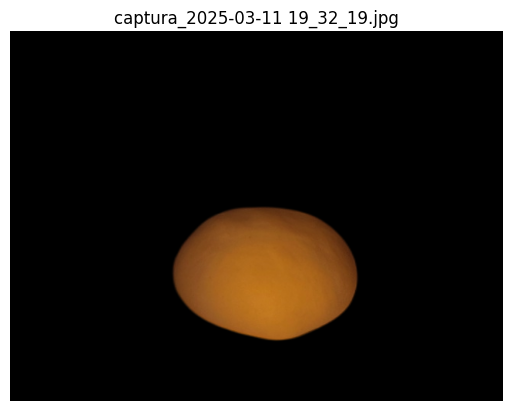

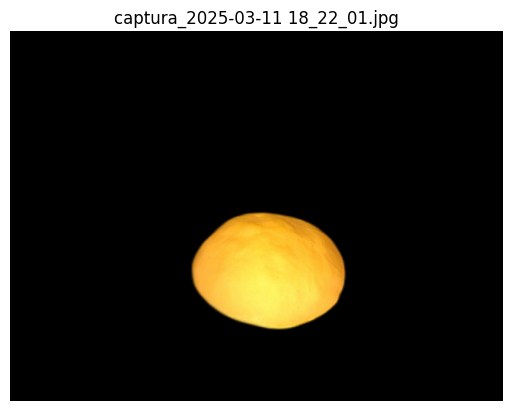

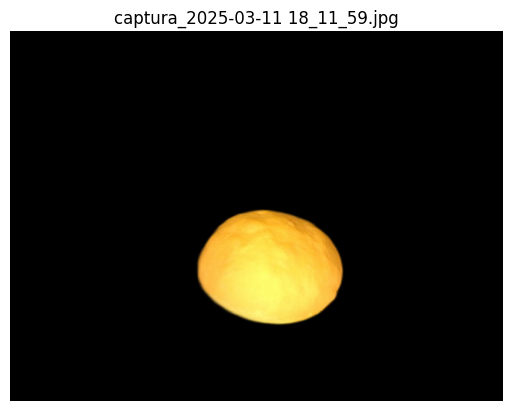

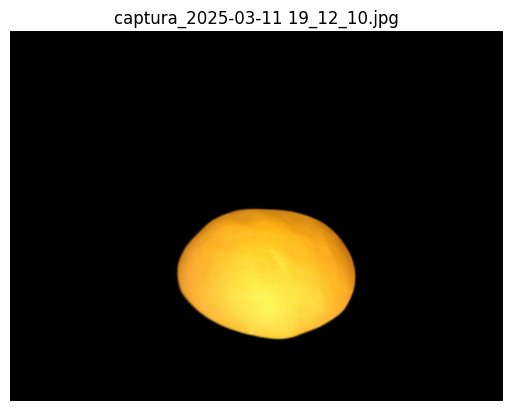

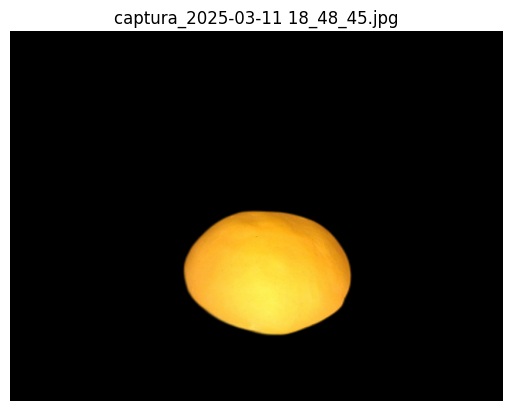

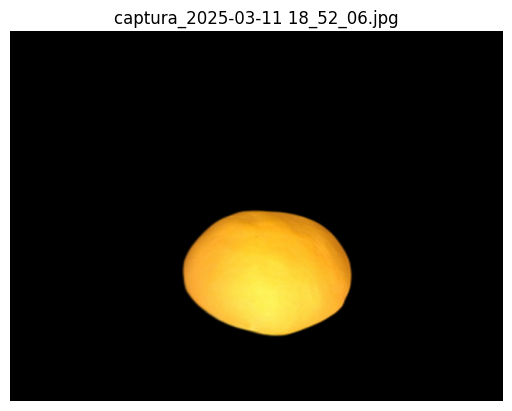

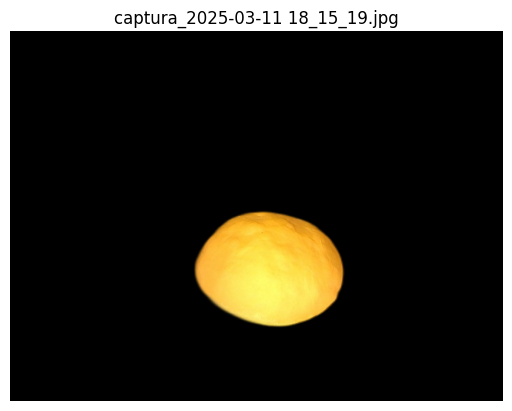

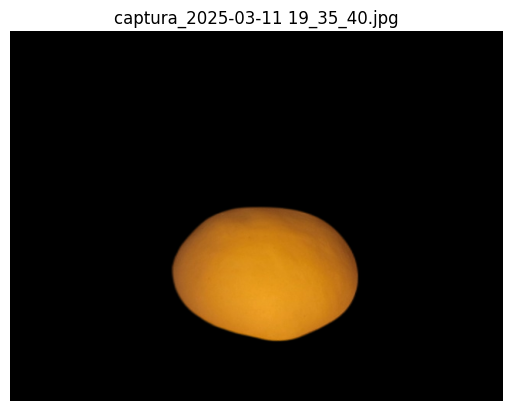

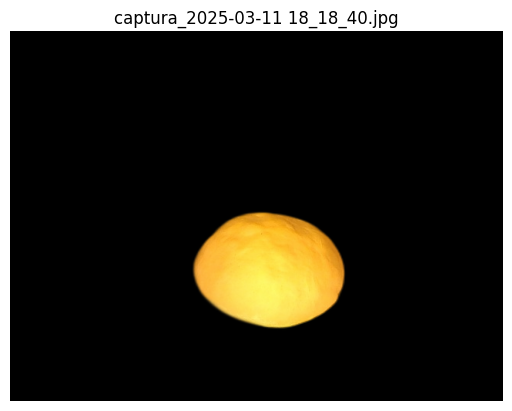

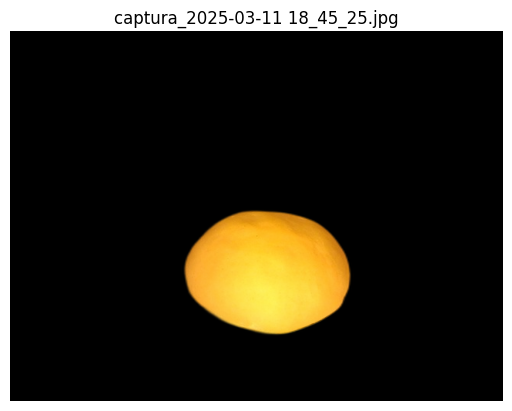

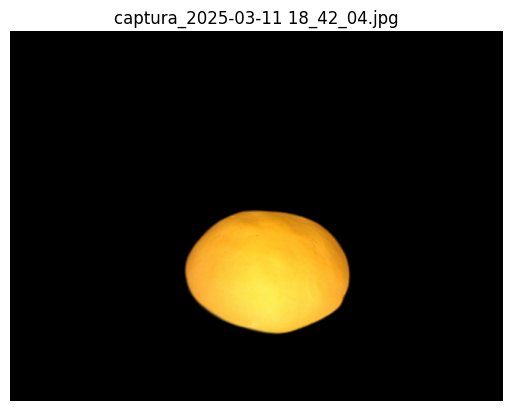

In [ ]:
# Get a list of all image files in the "pan" folder
folder_path = "Pan"  # Replace with the actual folder path
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
output_folder = "output_pan"

# Create the output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    # Remove background
    bread_image = remove_background(image_path)

    # Save the image with background removed
    output_path = os.path.join(output_folder, image_file)  # Use same filename
    bread_image.save(output_path)

    # Example: Display the image
    plt.imshow(bread_image)
    plt.title(image_file)  # Display the filename as title
    plt.axis("off")
    plt.show()

# Por diferencia de volumen según un Elipsoide

Usando la librería rembg https://github.com/danielgatis/rembg he quitado el fondo de la imagen para tratar solo lo que nos interesa en este caso que es el pan

Podemos considerar las masas casi como elipsoides partidos por la mitad
Por lo que podemos calcular el contorno del pan mediante el volumen del elipsoide

In [ ]:
# Get pixels_per_cm using a reference object
pixels_per_cm = 13 # Calculate from your known object

In [ ]:
def estimate_volume(image):
    image_cv = np.array(image)
    gray = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0, None

    largest_contour = max(contours, key=cv2.contourArea)

    if len(largest_contour) < 5:
        return 0, None

    ellipse = cv2.fitEllipse(largest_contour)
    (x, y), (major_axis, minor_axis), angle = ellipse

    c = 0.6 * major_axis
    volume = ((4 / 3) * np.pi * (major_axis / 2) * (minor_axis / 2) * (c / 2)) * 0.5

    return volume, ellipse

In [ ]:
def estimate_volume_cm3(image):
    volume, ellipse = estimate_volume(image)
    if ellipse is None:
        return 0, None

    (x, y), (major_axis, minor_axis), angle = ellipse
    major_axis_cm = major_axis / pixels_per_cm
    minor_axis_cm = minor_axis / pixels_per_cm
    c_cm = 0.6 * major_axis_cm
    volume_cm3 = ((4 / 3) * np.pi * (major_axis_cm / 2) * (minor_axis_cm / 2) * (c_cm / 2)) * 0.5

    return volume_cm3, ellipse

In [ ]:
def plot_volume_evolution():
    plt.figure(figsize=(10, 5))
    plt.plot(time_labels, volumes, marker='o')
    plt.xlabel("Tiempo Transcurrido")
    plt.ylabel("Volumen (cm³)")
    plt.title("Evolución del Volumen del Pan")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('output_pan/evolucion_volumen.png')  # Guardar gráfico como imagen
    plt.show()

In [ ]:
def process_images():
    folder_path = "Pan"
    image_files = sorted([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

    output_folder = "output_pan"
    os.makedirs(output_folder, exist_ok=True)

    global vol1, time_start
    first_ellipse = None
    volumen_inicial = None
    time_start = time.time()

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = remove_background(image_path)
        volume_cm3, ellipse = estimate_volume_cm3(image)
        tiempo_actual = time.time() - time_start

        if i == 0:
            vol1 = volume_cm3
            first_ellipse = ellipse
            volumen_inicial = volume_cm3
            continue

        image_cv = np.array(image)
        if ellipse:
            cv2.ellipse(image_cv, ellipse, (0, 255, 0), 2)
        if first_ellipse:
            cv2.ellipse(image_cv, first_ellipse, (0, 0, 255), 2)

        porcentaje_vol = (volume_cm3 / vol1) * 100
        minutos, segundos = divmod(int(tiempo_actual), 60)
        time_text = f"{minutos}m{segundos}s"

        cv2.putText(image_cv, f"Foto {i + 1}: {time_text}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(image_cv, f"Volumen estimado: {porcentaje_vol:.2f}%", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        if porcentaje_vol >= 150:
            for umbral in umbrales:
                if porcentaje_vol >= umbral:
                    cv2.putText(image_cv, f"AVISO > {umbral}%", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        output_path = os.path.join(output_folder, image_file)
        output_image = Image.fromarray(image_cv)
        output_image.save(output_path)

        # Almacenar el volumen y el tiempo
        volumes.append(volume_cm3)
        time_labels.append(time_text)

    # Llamar a la función de graficado
    plot_volume_evolution()

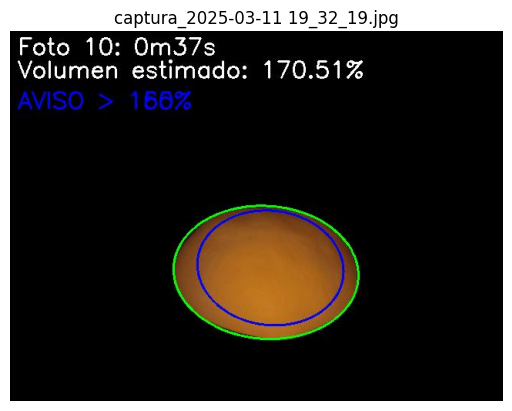

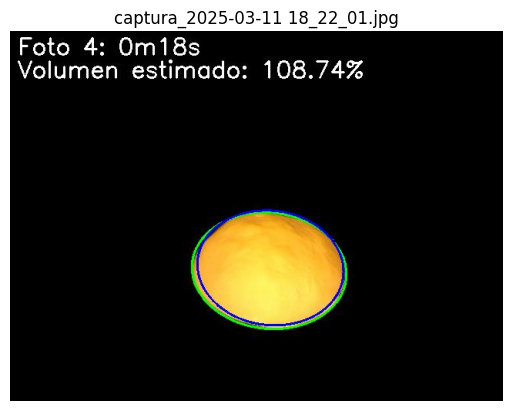

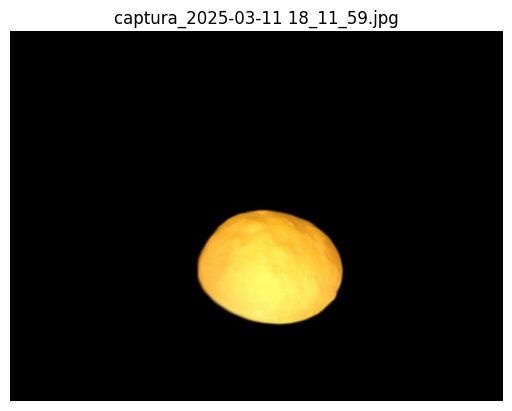

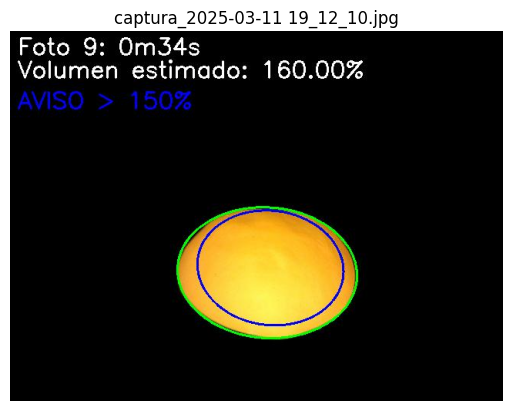

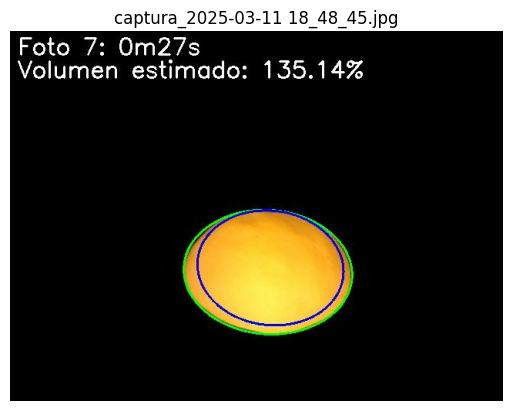

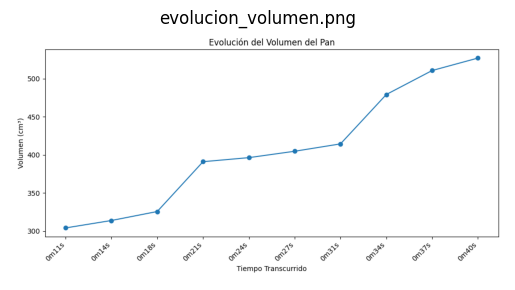

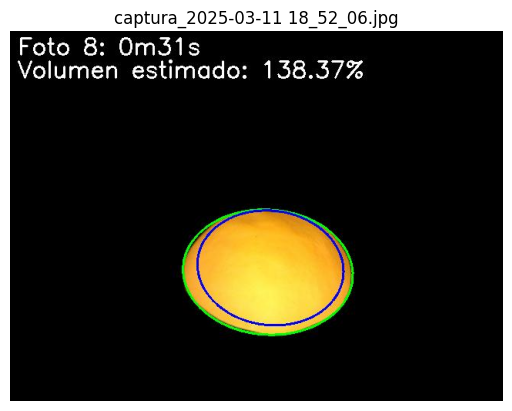

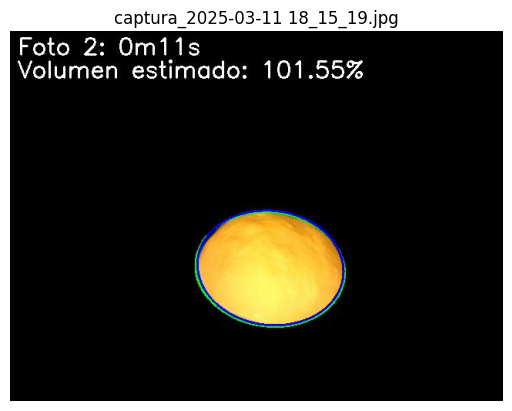

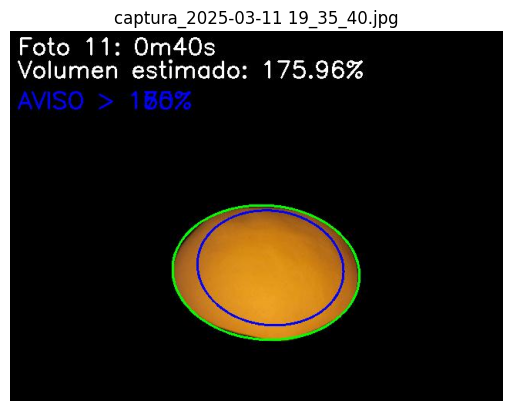

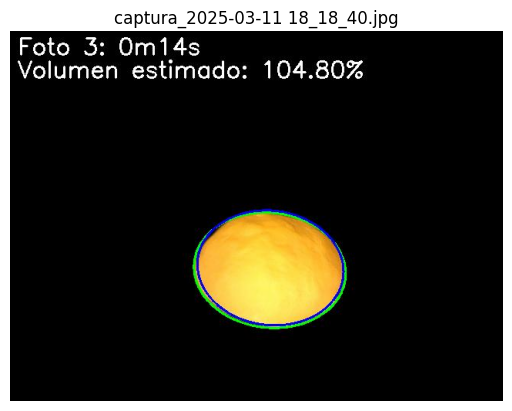

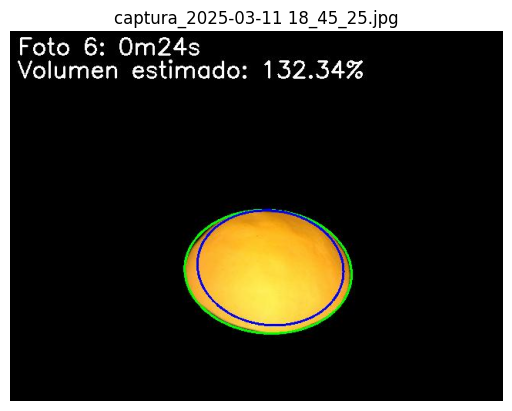

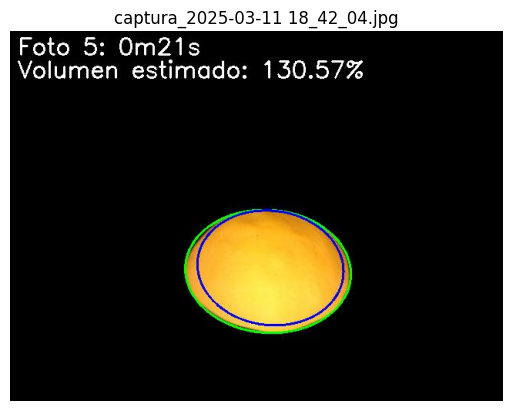

In [ ]:
# Assuming 'output_pan' directory exists and contains images
output_folder = "output_pan"
image_files = [f for f in os.listdir(output_folder) if os.path.isfile(os.path.join(output_folder, f))]

for image_file in image_files:
    image_path = os.path.join(output_folder, image_file)
    try:
        # Display the image using matplotlib
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying {image_file}: {e}")


Reglas Generales para la Fermentación del Pan
Duplicación del Volumen (Aumento del 80%-100%)

En la mayoría de los panes, la masa debe crecer 1.8x a 2x su volumen inicial antes de hornear.
Esto asegura una estructura adecuada y buena esponjosidad después del horneado.
Ejemplo: Si la masa inicial tiene 300 cm³, debería alcanzar entre 540 cm³ y 600 cm³ antes de hornear.
Sobrefermentación (>2.5x su volumen inicial)

Si la masa crece más de 2.5 veces su volumen inicial, la estructura puede colapsar durante el horneado.
Se vuelve pegajosa, débil y puede hundirse en el centro.
Fermentación Insuficiente (<1.5x su volumen inicial)

Si la masa no alcanza al menos 1.5 veces su volumen inicial, el pan será denso y poco aireado.

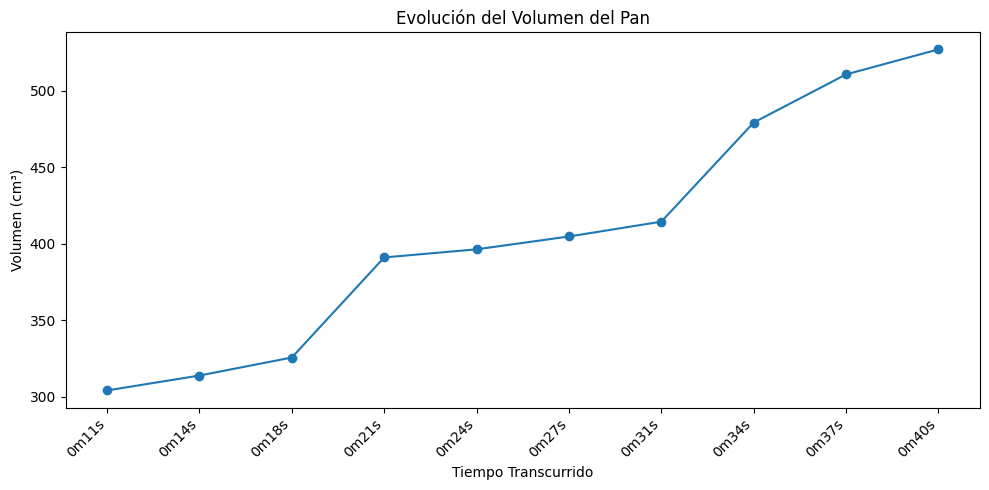

In [ ]:
process_images()